# streamlit（draft, use xai_dashboard.py)

## Basic model

In [1]:
#Importing all the libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from itertools import chain
from scipy import stats

from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

import xgboost
from xgboost import XGBRegressor

import torch
import torch.nn as nn
import os
from os import path
from sklearn.metrics import mean_squared_error
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [2]:
def splitting_data(X, y):
    column_names = list(X.columns)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=3)
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size = 0.25, random_state=3)
    return train_X, valid_X, test_X, train_y, test_y, valid_y, column_names


def scale_data(scalar, train_X, valid_X, test_X, column_names):
    scaler = scalar.fit(train_X)
    train_X = scaler.transform(train_X)
    valid_X = scaler.transform(valid_X)
    test_X = scaler.transform(test_X)

    train_X = pd.DataFrame(train_X)
    train_X.columns = column_names

    valid_X = pd.DataFrame(valid_X)
    valid_X.columns = column_names

    test_X = pd.DataFrame(test_X)
    test_X.columns = column_names

    return train_X, valid_X, test_X

df_numeric = pd.read_csv('XAI_data.csv')
non_binary = df_numeric.loc[:, df_numeric.apply(lambda x: x.nunique()) >= 3]

#We make a dataframe with only the non binary columns
df_outlier_removal = df_numeric[list(non_binary.columns)]

#The rows with an outlier in any of the columns get removed based on the z-score
df_outlier_removal = df_outlier_removal[(np.abs(stats.zscore(df_outlier_removal)) < 3).all(axis=1)]

df_binary = df_numeric.drop(columns=list(df_outlier_removal.columns))

#The final dataframe gets created based on the merge of the non-binary and the binary dataframes. 
#We make sure that only the rows that match index will be put in the dataframe so that only the rows
#without an outlier stay in the dataset
df_outlier = df_outlier_removal.merge(df_binary, left_index=True, right_index=True, how='inner')

df_outlier = df_outlier.reset_index(drop=True)

#An x and y get created baesd on the outlier data
X_outlier = df_outlier.drop(columns='Laatste vraagprijs')
y_outlier = df_outlier['Laatste vraagprijs']


train_X, valid_X, test_X, train_y, test_y, valid_y, column_names = splitting_data(X_outlier, y_outlier)

train_X, valid_X, test_X = scale_data(scalar=StandardScaler(), train_X=train_X, valid_X=valid_X, test_X=test_X, column_names=column_names)
model = XGBRegressor(n_estimators=80, max_depth=5, eta=0.1, silent=True)
model.fit(train_X, train_y)


[21:23:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

## create streamlit

In [4]:
!pip install streamlit


  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/eb/17/fc425e1d4d86e31b2aaf0812a2ef2163763a0670d671720c7c36e8679323/streamlit-1.44.1-py3-none-any.whl.metadata
  Obtaining dependency information for altair<6,>=4.0 from https://files.pythonhosted.org/packages/aa/f3/0b6ced594e51cc95d8c1fc1640d3623770d01e4969d29c0bd09945fafefa/altair-5.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for gitpython!=3.1.19,<4,>=3.0.7 from https://files.pythonhosted.org/packages/1d/9a/4114a9057db2f1462d5c8f8390ab7383925fe1ac012eaa42402ad65c2963/GitPython-3.1.44-py3-none-any.whl.metadata
  Obtaining dependency information for pydeck<1,>=0.8.0b4 from https://files.pythonhosted.org/packages/ab/4c/b888e6cf58bd9db9c93f40d1c6be8283ff49d88919231afe93a6bcf61626/pydeck-0.9.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for narwhals>=1.14.2 from https://files.pythonhosted.org/packages/80/b3/5781eb874f04cb1e882a7d93cf30abcb00362a3205c5f370

2025-04-16 21:32:56.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 21:32:56.791 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 21:32:56.792 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 21:32:56.792 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 21:32:56.793 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 21:32:56.794 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 21:32:56.802 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-16 21:32:56.803 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

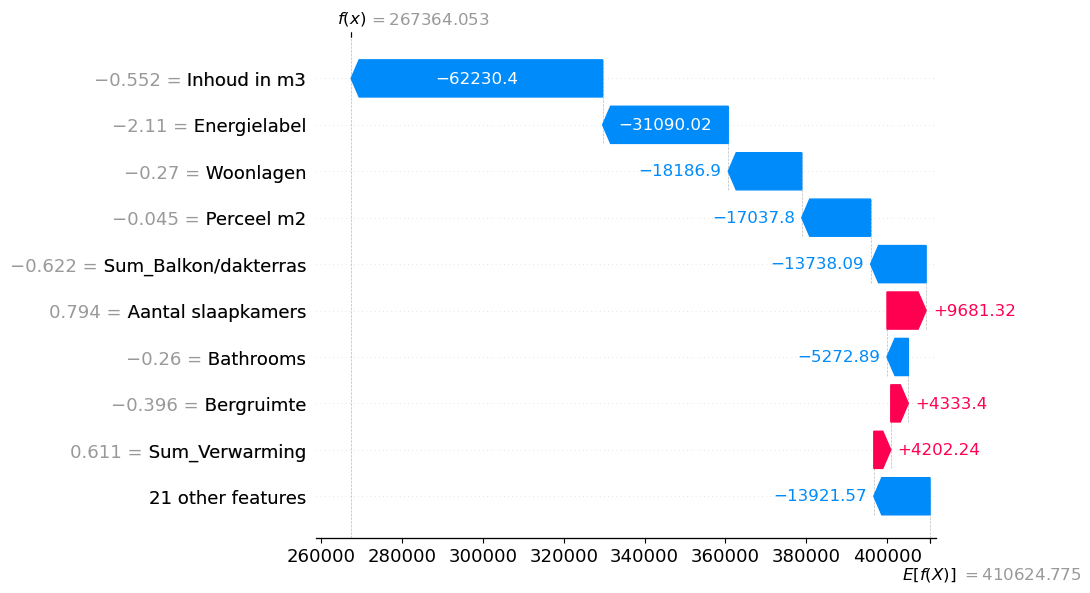

In [6]:
import streamlit as st
import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import streamlit.components.v1 as components

st.set_page_config(page_title="XAI Dashboard", layout="wide")
st.title("🔍 SHAP vs LIME Explanation Dashboard")

sample_idx = st.slider("Select a sample index", 0, len(test_X)-1, 0)
method = st.selectbox("Choose explanation method", ["SHAP", "LIME"])

X_sample = test_X.iloc[[sample_idx]]

@st.cache_resource
def get_shap_explainer():
    return shap.Explainer(model, test_X)

if method == "SHAP":
    st.subheader("SHAP Explanation")
    explainer = get_shap_explainer()
    shap_values = explainer(X_sample)

    fig, ax = plt.subplots(figsize=(10, 5))
    shap.plots.waterfall(shap_values[0], show=False)
    st.pyplot(fig)

elif method == "LIME":
    st.subheader("LIME Explanation")
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=np.array(train_X),
        feature_names=train_X.columns,
        mode='regression',
        verbose=False
    )
    lime_exp = lime_explainer.explain_instance(
        data_row=np.array(X_sample.iloc[0]),
        predict_fn=model.predict
    )
    html = lime_exp.as_html()
    components.html(html, height=800, scrolling=True)

# ================= 模型输出信息 ===================
st.markdown("---")
st.markdown(f"**Predicted value**: `{model.predict(X_sample)[0]:,.2f}`")
st.markdown(f"**True value**: `{test_y.iloc[sample_idx]:,.2f}`")

# ================= 用户反馈区域 ===================
st.markdown("## 💬 User Feedback")
st.radio("Which explanation is easier to understand?", ["SHAP", "LIME", "Both equally", "Neither"])
st.radio("Which explanation do you trust more?", ["SHAP", "LIME", "Both equally", "Neither"])
feedback = st.text_area("Any comments or suggestions?")

if st.button("Submit Feedback"):
    st.success("✅ Thank you for your feedback!")

In [8]:
!streamlit run xai_dashboard.py




      👋 Welcome to Streamlit!

      If you’d like to receive helpful onboarding emails, news, offers, promotions,
      and the occasional swag, please enter your email address below. Otherwise,
      leave this field blank.

      Email:  ^C
